In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from MakeSyntheticSeismic import MakeSeismic, PlotSeis
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
# Generating images 
num_img = 1000
# clean_signal, noise, noisy_signal = MakeSeismic(samples=num_img,img_size=128,num_events=8)
clean_signal2, noise2, noisy_signal2 = MakeSeismic(samples = num_img,img_size= 256,num_events=8)

In [ ]:
PlotSeis([clean_signal2,noise2,noisy_signal2],num=3)

In [ ]:
# #Scaling the data between 0 and 1 before it goes into the network
# scalers_ns = {}
# clean_signal_sc = np.zeros_like(clean_signal)
# noisy_signal_sc = np.zeros_like(noisy_signal)
# for i in range(clean_signal.shape[0]):
#     scalers_ns[i] = MinMaxScaler(feature_range=(-1,1))
#     # noisy_signal_sc[i, :, :, 0] = scalers_ns[i].fit_transform(noisy_signal[i, :, :, 0]) 
#     noisy_signal_sc[i, :, :, 0] = noisy_signal[i,:,:,0] / np.max(np.abs(noisy_signal[i,:,:,0]))
#     clean_signal_sc[i, :, :, 0] = clean_signal[i,:,:,0] / np.max(np.abs(clean_signal[i,:,:,0]))

In [ ]:
# Splitting 100 images into windows to pass through the ANN autoencoder
cs_windows = []
ns_windows = []
for iImg in range(num_img):
    cs_windows.append(img2windows(clean_signal2[iImg,:,:,0],16,16))
    ns_windows.append(img2windows(noisy_signal2[iImg,:,:,0],16,16))

cs_windows = np.array(cs_windows)
ns_windows = np.array(ns_windows)

In [ ]:
plt.subplot(1,2,1)
plt.imshow(cs_windows[0,10])
plt.gray()
plt.title('Clean Window')
plt.subplot(1,2,2)
plt.imshow(ns_windows[0,10])
plt.gray()
plt.title('Noisy Window')

In [ ]:
# Generating training and testing data
NS_train_wind, NS_test_wind, S_train_wind, S_test_wind = train_test_split(ns_windows,cs_windows, test_size=0.33, random_state = 21)
NS_train_trc, NS_test_trc, S_train_trc, S_test_trc = train_test_split(noisy_signal2,clean_signal2, test_size=0.33, random_state = 21)

In [ ]:
# Custom loss functions

# y_true = target = clean image = X_train
# y_pred = clean output

# max structural similarity index between original image and denoised imaged 
def ssim_loss(y_true, y_pred):
  return 1-reduce_mean(ssim(y_true, y_pred, 1.0, filter_size=5))

In [ ]:
NS_train_trc.shape

In [ ]:
# Reshaping images before they go into ANN
NS_train_wind_resh = NS_train_wind.reshape(670*256,256)
S_train_wind_resh = S_train_wind.reshape(670*256,256)
NS_test_wind_resh = NS_test_wind.reshape(330*256,256)
S_test_wind_resh = S_test_wind.reshape(330*256,256)


# Splitting out the traces into a single continuous file
NS_train_trc_resh = NS_train_trc.reshape(670*256,256)
S_train_trc_resh = S_train_trc.reshape(670*256,256)
NS_test_trc_resh = NS_test_trc.reshape(330*256,256)
S_test_trc_resh = S_test_trc.reshape(330*256,256)

In [ ]:
# modelUnet = autoencoder("Unet",start_filters=8)
# modelUnetMSE = autoencoder("Unet_NoSc",start_filters=8)
# modelUnetBCE = autoencoder("Unet",start_filters=8)
# modelUpSc = autoencoder("upsc")
# modelUnetNoSc = autoencoder("Unet_NoSc",start_filters=8)

# modelANN_wind = autoencoder("ANN")
# modelANN_trc = autoencoder("ANN")
modelANN_wind_dr = autoencoder("ANN_dr")
modelANN_trc_dr = autoencoder("ANN_dr")

In [13]:
# modelUnet.compile(loss=ssim_loss,optimizer='adam',metrics=[ssim_loss])
# modelUnetMSE.compile(loss='mse',optimizer='adam')
# modelUpSc.compile(loss=ssim_loss,optimizer='adam',metrics=[ssim_loss])
# modelUnetNoSc.compile(loss=ssim_loss,optimizer='adam',metrics=[ssim_loss])
# modelUnetMSE.compile(loss='mse',optimizer='adam')
# modelUnetBCE.compile(loss='binary_crossentropy',optimizer='adam')
# modelANN_wind.compile(loss='mse',optimizer='adam')
# modelANN_trc.compile(loss='mse',optimizer='adam')

modelANN_wind_dr.compile(loss='mse',optimizer='adam')
modelANN_trc_dr.compile(loss='mse',optimizer='adam')

In [14]:
# Creating callback for training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0002,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [15]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# model_checkpoint_callback = ModelCheckpoint(
#     filepath='checkpoint_filepath',
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [48]:
# batch_size= 128
# epochs = 50
# modelANN_trc_hist = modelANN_trc.fit(NS_train_trc_resh, S_train_trc_resh, batch_size = batch_size, epochs = epochs,validation_data =(NS_test_trc_resh,S_test_trc_resh),use_multiprocessing=True)

In [49]:
# batch_size= 128
# epochs = 50
# modelANN_wind_hist = modelANN_wind.fit(NS_train_wind_resh, S_train_wind_resh, batch_size = batch_size, epochs = epochs,validation_data =(NS_test_wind_resh,S_test_wind_resh),use_multiprocessing=True)

In [ ]:
batch_size= 128
epochs = 50
modelANN_trc_dr_hist = modelANN_trc_dr.fit(NS_train_trc_resh, S_train_trc_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_trc_resh,S_test_trc_resh),use_multiprocessing=True)

In [ ]:
batch_size= 128
epochs = 50
modelANN_wind_dr_hist = modelANN_wind_dr.fit(NS_train_wind_resh, S_train_wind_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_wind_resh,S_test_wind_resh),use_multiprocessing=True)

In [59]:
# hists = pd.DataFrame(modelANN_trc_hist.history)
# hists["model"]="ANN_trc_2"
hists = pd.read_csv('/Users/Graham/Documents/Programming/GitHub/ML/AutoEncoderImageDenoise/models/perf/hists.csv')
hists= store_hist(hists,pd.DataFrame(modelANN_wind_dr_hist.history),'ANN_wind_dr')
hists= store_hist(hists,pd.DataFrame(modelANN_trc_dr_hist.history),'ANN_trc_dr')


hists.to_csv('/Users/Graham/Documents/Programming/GitHub/ML/AutoEncoderImageDenoise/models/perf/hists.csv')


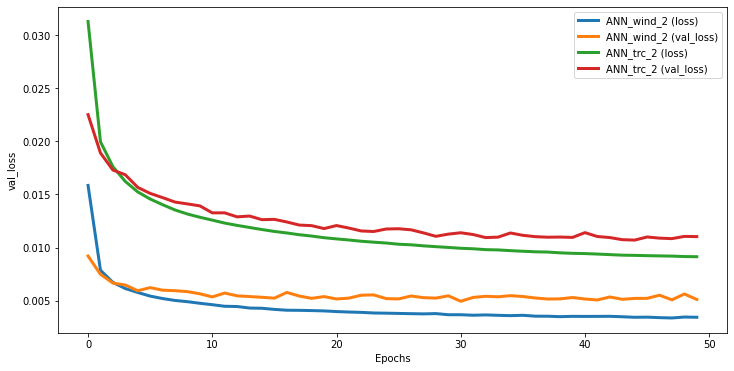

In [47]:
plot_perf(hists,['ANN_wind_2','ANN_trc_2'],['loss','val_loss'])

In [22]:
# modelUnetMSE.save('./models/UnetMSE_16filt')
# modelUnetMSE.save('./models/UnetMSE_8filt')
modelANN_wind_dr.save('./models/ANN_wind_dr')
modelANN_trc_dr.save('./models/ANN_trc_dr')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [20]:
from tensorflow.keras.models import load_model

In [23]:
# Predicting

# pred = modelUnet.predict(NS_test)
# pred2 = modelUnet.predict(ns_test)
# predmse = modelUnetMSE.predict(NS_test_nosc)
# predmse3 = modelUnetMSE.predict(NS_test_nosc)

# pred_upsc = modelUpSc.predict(ns_test)
# pred_nosc = modelUnetNoSc.predict(NS_test_nosc)

predANN_wind = modelANN_wind.predict(NS_test_wind_resh)
predANN_trc = modelANN_trc.predict(NS_test_trc_resh)

In [26]:
# Reshaping predictions
predANN_wind_resh = predANN_wind.reshape(int(predANN_wind.shape[0]/256),256,16,16)

decoded_imgANN_wind = []
orig_noisy = []
orig_clean = []
for iImg in range(330):
    decoded_imgANN_wind.append(windows2img(predANN_wind_resh[iImg],256,256))
    orig_noisy.append(windows2img(NS_test_wind[iImg],256,256))
    orig_clean.append(windows2img(S_test_wind[iImg],256,256))

decoded_imgANN_wind = np.array(decoded_imgANN_wind)
orig_noisy = np.array(orig_noisy)
orig_clean = np.array(orig_clean)

In [27]:
decoded_imgANN_trc = predANN_trc.reshape(330,256,256,1)

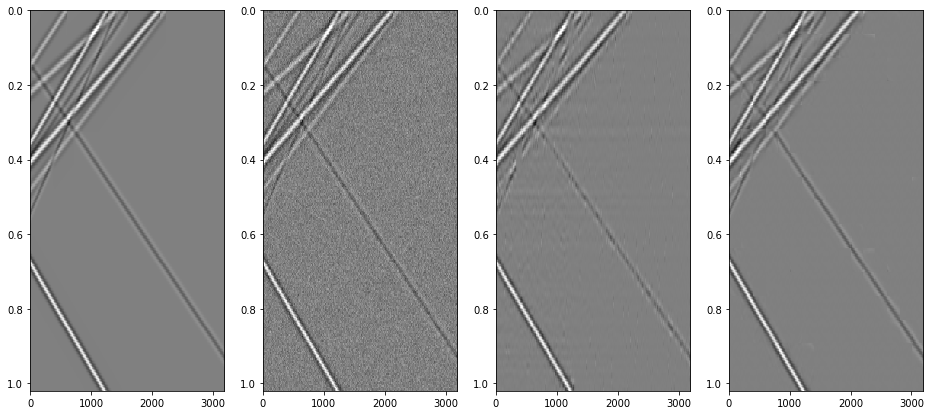

In [46]:
PlotSeis([orig_clean,orig_noisy,decoded_imgANN_trc,decoded_imgANN_wind],num=19)